In [33]:
import tifffile
import numpy as np
from skimage.color import rgb2hed, hed2rgb
from skimage import filters, morphology, measure, segmentation, color, feature
from skimage.io import imread, imshow
from skimage.segmentation import watershed, find_boundaries
from skimage.feature import peak_local_max
from skimage.exposure import equalize_adapthist, equalize_hist
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.util import crop
import pandas as pd
from skimage.draw import polygon

In [68]:
his_path = "./data/D016-RLL-11B2-6_Scan1.qptiff"
#cod_path = "./data/D016-RLL-11B2-6_Scan3.qptiff"

In [70]:
with tifffile.TiffFile(his_path) as tif:
    he = tif.pages[0].asarray()

In [71]:
print(he.shape)

(48960, 32640, 3)


In [72]:
hed = rgb2hed(he)
h = hed[:,:,0]
#plt.imshow(h,cmap='gray')

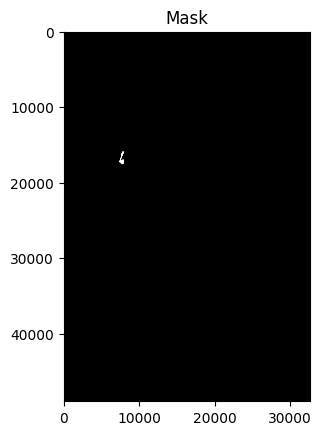

In [105]:
# load mask
def parse_json_features(json_data):
    nuclei_annotations = []
    for feature in json_data['features']:
        if feature['geometry']['type'] == 'Polygon':
            vertices = feature['geometry']['coordinates'][0]  # First ring
            vertices = [(int(coord[0]), int(coord[1])) for coord in vertices]  # Assuming (x, y) format
            nuclei_annotations.append(vertices)
    return nuclei_annotations

def create_ground_truth_mask(image_shape, nuclei_annotations):
    ground_truth_mask = np.zeros(image_shape, dtype=np.uint8)
    for annotation in nuclei_annotations:
        rr, cc = polygon([v[1] for v in annotation], [v[0] for v in annotation], image_shape)
        ground_truth_mask[rr, cc] = 1
    return ground_truth_mask

# Load GeoJSON file into pandas DataFrame
json_file = 'HE.geojson'
json_data = pd.read_json(json_file)

# Parse JSON features
nuclei_annotations = parse_json_features(json_data)

image_shape = he.shape[:2]

mask = create_ground_truth_mask(image_shape, nuclei_annotations)

plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.show()

In [106]:
mask_he = np.expand_dims(mask, axis=-1)*he
mask_h = mask*h.squeeze()

In [107]:
# Find the indices where the mask value is 1
roi_indices = np.where(mask == 1)

# Get the minimum and maximum x and y coordinates
min_x = np.min(roi_indices[1])
max_x = np.max(roi_indices[1])
min_y = np.min(roi_indices[0])
max_y = np.max(roi_indices[0])

print(min_x,max_x,min_y,max_y)

7222 7980 15866 17620


In [108]:
roi_h = mask_h[min_y:max_y,min_x:max_x]
roi_he = mask_he[min_y:max_y,min_x:max_x]

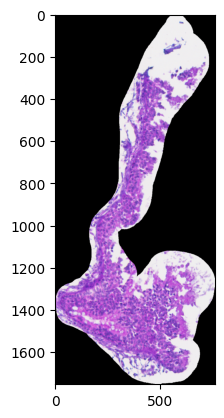

In [109]:
plt.imshow(roi_he)

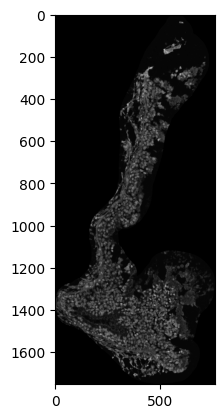

In [110]:
plt.imshow(roi_h,'gray')

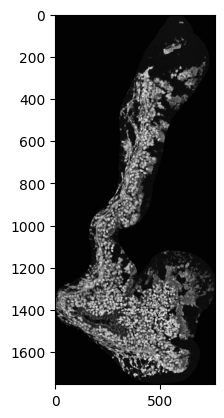

In [111]:
h_histeq = equalize_adapthist(roi_h)
plt.imshow(h_histeq,cmap='gray')

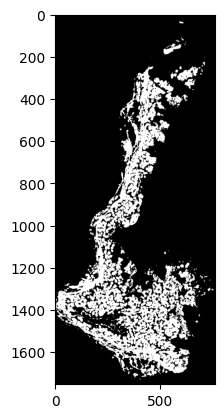

In [112]:
# Thresholding
thresh = filters.threshold_otsu(h_histeq)
binary = h_histeq > thresh
plt.imshow(binary,cmap='gray')

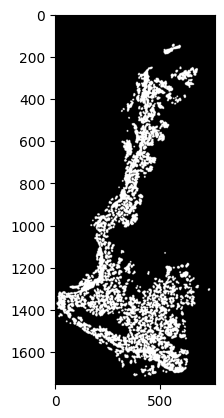

In [113]:
open = morphology.binary_opening(binary, morphology.disk(4))
plt.imshow(open,cmap='gray')

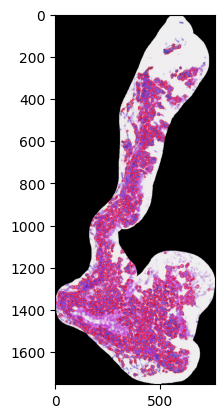

In [117]:
distance = ndi.distance_transform_edt(open)
coords = peak_local_max(distance, footprint=np.ones((10, 10)), labels=open)
dist_mask = np.zeros(distance.shape, dtype=bool)
dist_mask[tuple(coords.T)] = True
markers, _ = ndi.label(dist_mask)

# Watershed segmentation
labels = watershed(-distance, markers, mask=open)

# Find boundaries of watershed elements
boundaries = find_boundaries(labels)

# Overlay the segmented nuclei on the original color image
overlaid_image = roi_he.copy()
overlaid_image[boundaries] = [255, 0, 0]  # Red color for boundaries

plt.imshow(overlaid_image)
plt.savefig('HE_seg.png',dpi=1000)

# registraition

In [13]:
import cv2 as cv

In [14]:
# resize
resize_factor = 1/10
he_rs = cv.resize(he, (0,0),fx = resize_factor, fy = resize_factor)

In [15]:
he_rs.shape

(4896, 3264, 3)

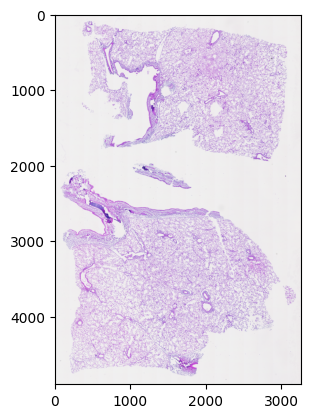

In [16]:
plt.imshow(he_rs)